In [28]:
#imports
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import time
from scipy.io import wavfile as wav
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics 
#keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils

In [2]:
#Settings
audio_dataset_path = "C:\\Users\\Filip\\Desktop\\Jupyter\\wav_dataset"
#test files for prediction
test_file_on = audio_dataset_path+"\\"+"on"+"\\"+"3cc595de_nohash_1.wav"
test_file_down = audio_dataset_path+"\\"+"down"+"\\"+"b87bdb22_nohash_1.wav"
test_file_right = audio_dataset_path+"\\"+"right"+"\\"+"2aca1e72_nohash_1.wav"
class_label = ["down","go","left","on","right","stop","up"]
#wav_sample_rate = 16000
num_mfcc = 40
#number of spectrograms to make (per class)
num_files = 1500
num_epochs = 40
num_batch = 64
#padding for mfcc spectrograms 
PADDING = 64

In [3]:
#make mfc spectrogram out of .wav file and apply padding to it
def get_spectrogram(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc = num_mfcc)
        pad = PADDING - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0), (0,pad)), mode="constant")
    except Except as err:
        print("Error with file: ", file_name)
        return None, None
    return mfcc

In [4]:
#iterate through all of files in dataset and make spectrograms out of them
#save spectrograms in numpy DataFrame (excel-like sheet)
def spectro_bot(dataset_path):
    entries = []
    start_time = time.time()
    for dir_name in class_label:
        print(dir_name)
        label_index = class_label.index(dir_name)
        dir_path = dataset_path+"\\"+dir_name
        i = 0
        for file_name in os.listdir(dir_path):
            file_path = dir_path+"\\"+file_name
            data = get_spectrogram(file_path)
            entries.append([data, label_index])
            i=i+1
            if (i==num_files):
                break
    entries_data_frame = pd.DataFrame(entries, columns=["entries", "label"])
    entries_data_frame = entries_data_frame.sample(frac=1).reset_index(drop=True)
    finish_time = time.time()
    print("Finished processing {} files in {} seconds".
          format(len(entries_data_frame), finish_time-start_time))
    return entries_data_frame

In [5]:
#make spectrograms
data_frame = spectro_bot(audio_dataset_path)
#move dataframe entries into np. array
X = np.array(data_frame.entries.tolist())
y = np.array(data_frame.label.tolist())

#encode labels
encoder = LabelEncoder()
encoded_labels = to_categorical(encoder.fit_transform(y))

#split dataset
x_train, x_test, y_train, y_test = train_test_split(X, encoded_labels,
                                                    test_size=0.25,
                                                    random_state = 42)

#reshape
num_rows = num_mfcc
num_columns = PADDING
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
num_labels = encoded_labels.shape[1]

down
go
left
on
right
stop
up
Finished processing 10500 files in 147.6114149093628 seconds


In [30]:
#=============================CNN MODEL===============================
model = Sequential()
#first conv
model.add(Conv2D(filters=16, kernel_size=3,
                 input_shape=(num_rows, num_columns, num_channels),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [31]:
#compile
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
model.summary()
#pre-training acc
acc = model.evaluate(x_test,y_test,verbose=1)
print("Pre training: {}".format(100*acc[1]))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 38, 62, 16)        160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 19, 31, 16)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 19, 31, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 17, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 9, 15, 32)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 9, 15, 32)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 13, 64)        

In [32]:
#train
start_time = time.time()
history = model.fit(x_train, y_train,
                    batch_size=num_batch, 
                    epochs=num_epochs, 
                    validation_data=(x_test, y_test), 
                    verbose=1)
finish_time = time.time() - start_time
print("Training time: {} seconds".format(finish_time))

Train on 7875 samples, validate on 2625 samples
Epoch 1/60
7875/7875 [==============================] - 13s 2ms/step - loss: 2.2716 - accuracy: 0.1968 - val_loss: 1.7663 - val_accuracy: 0.3379
Epoch 2/60
7875/7875 [==============================] - 14s 2ms/step - loss: 1.6927 - accuracy: 0.3297 - val_loss: 1.3418 - val_accuracy: 0.5318
Epoch 3/60
7875/7875 [==============================] - 13s 2ms/step - loss: 1.2765 - accuracy: 0.5167 - val_loss: 0.8612 - val_accuracy: 0.7017
Epoch 4/60
7875/7875 [==============================] - 13s 2ms/step - loss: 1.0153 - accuracy: 0.6281 - val_loss: 0.6774 - val_accuracy: 0.7897
Epoch 5/60
7875/7875 [==============================] - 13s 2ms/step - loss: 0.8218 - accuracy: 0.7145 - val_loss: 0.5664 - val_accuracy: 0.8312
Epoch 6/60
7875/7875 [==============================] - 12s 2ms/step - loss: 0.7520 - accuracy: 0.7302 - val_loss: 0.4580 - val_accuracy: 0.8495
Epoch 7/60
7875/7875 [==============================] - 13s 2ms/step - loss: 0.650

Epoch 57/60
7875/7875 [==============================] - 13s 2ms/step - loss: 0.1653 - accuracy: 0.9444 - val_loss: 0.1573 - val_accuracy: 0.9474
Epoch 58/60
7875/7875 [==============================] - 12s 2ms/step - loss: 0.1505 - accuracy: 0.9490 - val_loss: 0.1671 - val_accuracy: 0.9421
Epoch 59/60
7875/7875 [==============================] - 12s 2ms/step - loss: 0.1743 - accuracy: 0.9418 - val_loss: 0.1641 - val_accuracy: 0.9459
Epoch 60/60
7875/7875 [==============================] - 13s 2ms/step - loss: 0.1635 - accuracy: 0.9451 - val_loss: 0.1709 - val_accuracy: 0.9463
Training time: 772.394611120224 seconds


In [33]:
#evaluate
acc = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", acc[1])
acc = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", acc[1])

Training Accuracy:  0.99657142162323
Testing Accuracy:  0.9462857246398926


In [34]:
#make prediction and print it in human-readable format
def make_prediction(file_name, model):
    spectro = get_spectrogram(file_name)
    spectro = spectro.reshape(1, num_rows, num_columns, num_channels)
    prediction = model.predict_classes(spectro)
    predicted_class = encoder.inverse_transform(prediction)
    
    print("Predicted class:", class_label[predicted_class[0]], '\n') 
    
    #probabilities
    prediction_prob = model.predict_proba(spectro) 
    predicted = prediction_prob[0]
    for i in range(len(predicted)): 
        category = encoder.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted[i], '.32f') )


In [37]:
make_prediction(test_file_right, model)

Predicted class: right 

0 		 :  0.00000050886495728263980709016323
1 		 :  0.00000010396402672085969243198633
2 		 :  0.00271651265211403369903564453125
3 		 :  0.00000048116788775587338022887707
4 		 :  0.99727708101272583007812500000000
5 		 :  0.00000181030634394119260832667351
6 		 :  0.00000352867073161178268492221832


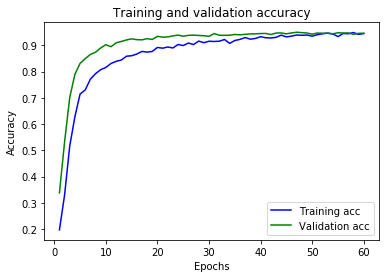

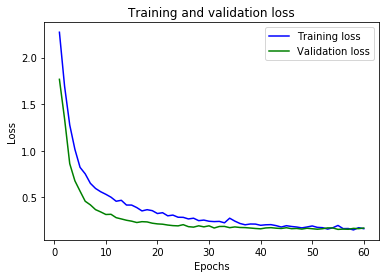

In [38]:
#plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()